## Make the openAI client and read in game information 

In [3]:
from dotenv import load_dotenv
from openai import OpenAI
import os 

load_dotenv()

True

In [4]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [36]:
import json
import random

# Load JSON file
with open("npc.json", "r") as file:
    npc_data = json.load(file)

## Define memory class, including save state

In [ ]:
game_state = {
    "player": None, 
    "player_weapon_maxed": False, 
    "player_weapon": None, 
    "group": None, 
    "inventory": [],
    "available_locations": {
        "village_locations": {
            "Village Center": {
                "description": None, 
                "available_interactables": None
            },
            "Tavern": {
                "description": None, 
                "available_interactables": None, 
                "available_quests": None
            },
            "Blacksmith": {
                "description": None, 
                "shop_items": None
            },
            "Apothecary": {
                "description": None, 
                "shop_items": None
            }, 
            "Dungeon": {
                "description": None
            }
        },
        "dungeon_rooms": {
            "r1": {
                "description": None, 
                "available_interactions": None
            },
        },
        "curr_village_location": "Village Center", 
        "curr_dungeon_location": None
    },
    "current_location": "Village Center",
    "spawned_npcs": [],
    "dungeon_rooms_visited": None, 
    "active_quests": None, 
    "current_map": None, 
    "current_dungeon": None, 
    "enemies": [],
}

In [7]:
char_info = { 
    "class_name": "",
    "hp_full": 0, 
    "hp_curr": 0, 
    "atk_base": 0,
    "atk_curr": 0,
    "weapon": "", 
}

In [8]:
interactions = [ "" ]

In [9]:
from langchain_community.vectorstores.faiss import FAISS
from langchain_openai import OpenAIEmbeddings
class Memory(): 
    def __init__(self): 
        pass 

    def intialize_memory(self, interactions): 
        return FAISS.from_texts(texts=interactions, embedding=OpenAIEmbeddings())

    def close_game(self, game_state, interactions, character_info): 

        if not os.path.exists("save_state.json") or os.path.getsize("save_state.json") ==0: 
            with open("save_state.json", "w") as file: 
                to_save = {
                    "game_state": game_state, 
                    "interactions": interactions, 
                    "character_info": char_info,
                }
                json.dump(to_save, file)

        to_save = {
            "game_state": game_state, 
            "interactions": interactions, 
            "character_info": char_info,
        }

        with open("save_state.json", "w") as file: 
            json.dump(to_save, file)
            
    def player_killed(self): 
        game_state = {
            "player": None, 
            "player_weapon_maxed": False, 
            "player_weapon": None, 
            "group": None, 
            "inventory": [],
            "available_locations": [],
            "current_location": "Village",
            "spawned_npcs": [],
            "dungeon_levels": [], 
            "dungeon_rooms_visited": None, 
            "active_quests": None, 
            "current_map": None, 
            "current_dungeon": None, 
            "enemies": [],
        }
        char_info = { 
            "class_name": "",
            "hp_full": 0, 
            "hp_curr": 0, 
            "atk_base": 0,
            "atk_curr": 0,
            "weapon": "", 
        }
        interactions = [ "" ]
        self.close_game(game_state, interactions, char_info)

    def start_game(self, file): 
        if file is None: 
            return self.intialize_memory([""])
        if not os.path.exists(file) or os.path.getsize(file) == 0: 
            with open(file, "w") as file: 
                to_save = {
                    "game_state": [""], 
                    "interactions": [""],
                    "character_info": [""], 
                }
                json.dump(to_save, file)

        with open(file, "r") as file: 
            existing_data = json.load(file)
        if 'game_state' in existing_data: 
            game_state = existing_data['game_state']
        if 'character_info' in existing_data: 
            char_info = existing_data['character_info']
            if 'weapon' in char_info: 
                game_state['player_weapon'] = char_info['weapon']
        if 'interactions' in existing_data: 
            interactions = existing_data['interactions']
        return self.intialize_memory(existing_data)
    

## Define a class for the Character 

In [10]:
class Character:
    def __init__(self, name, char_class):
        with open("characters.json", "r") as file: 
            character_info = json.load(file)
        self.name = name
        self.char_class = char_class
        character_class = character_info[char_class]
        self.hp = character_class['base_stats']['hp']
        self.atk = character_class['base_stats']['atk']
        self.wpn = character_class['weapon']
        char_info['class_name'] = self.char_class
        char_info['hp_full'] = self.hp
        char_info['hp_curr'] = self.hp
        char_info['atk_base'] = self.atk
        char_info['atk_curr'] = self.atk 
        char_info['weapon'] = self.wpn
    
    def skill_check(self, success): 
        randGen = random.randint(1, 10)
        if randGen >= int(success): 
            return "Skill check successful"
        else: 
            return "Skill check unsuccessful"
    
        
    def damage_taken(self, damage):
        curr_health = char_info['hp_curr'] 
        float_health = float(curr_health)
        float_health -= float(damage)
        char_info['hp_curr'] = float_health
        print(f"Current health is now: {float_health}")
    
    def heal(self, heal): 
        curr_health = char_info['hp_curr']
        max_health = char_info['hp_full']
        if (float(curr_health) + float(heal) > max_health ): 
            char_info['hp_curr'] = char_info['hp_full']
        else: 
            char_info['hp_curr'] = float(curr_health + float(heal))

## Define a class for the village NPCs

In [11]:
class VillageNPC(): 
    def __init__(self): 
        pass

    def check_spawn_criteria(self, criteria, game_state):
        # If there are no criteria or it's explicitly "none," always return True
        if not criteria or criteria.lower() == "none":
            return True
        
        # Examples of specific criteria checks
        if "weapon" in criteria.lower() and "max capacity" in criteria.lower():
            # Check if the player's weapon is not upgraded to max
            return not game_state.get("player", {}).get("weapon_upgraded", False)

        if "has something in inventory" in criteria.lower():
            # Check if the player has any items in their inventory
            inventory = game_state.get("player", {}).get("inventory", [])
            return len(inventory) > 0

        # Additional custom criteria can be added here
        # Example: criteria for player's level or quest progress
        if "level" in criteria.lower():
            level_required = int(criteria.split()[-1])  # Extract level from criteria
            return game_state.get("player", {}).get("level", 0) >= level_required
        
        # If no matching criteria logic is implemented, return False by default
        print(f"Unknown criteria: {criteria}")
        return False
    
  # Function for spawning npcs
    def spawn_npc(self, location, game_state):
        spawned_npcs = []
        for npc in npc_data["Village Friends"]:
            if (npc["location"] == location and
                #check_spawn_criteria(npc["spawn_criteria"], game_state) and
                random.random() <= npc["spawn_chance"]):
                spawned_npcs.append(npc)
        return spawned_npcs
    

## Define a class for the DungeonNPCs

In [12]:
class DungeonNPC(): 
    def __init__(self): 
        pass

    # Function to spawn a single enemy randomly based on spawn chance
    def spawn_random_enemy(self):
        # Filter enemies that can spawn based on their spawn chance
        potential_enemies = [enemy for enemy in npc_data["enemies"] if random.random() <= enemy.get("spawn_chance", 1)]
        
        if potential_enemies:
            # Randomly select one enemy from the list of enemies that passed the spawn chance check
            enemy_to_spawn = random.choice(potential_enemies)
            return enemy_to_spawn
        else:
            print("No enemies appeared this time.")
            return None

    # Function to print enemy details
    def get_enemy_details(enemy):
        return f"{enemy['name']} - {enemy['description']}\nHealth: {enemy['health']} - Attack Power: {enemy['attack_power']}"
        

## Maps and Locations

In [28]:
import matplotlib.pyplot as plt
import networkx as nx #python package for networks
import numpy as np

### Location class

In [14]:
# Creates location object and bidirectional connection between locations
class Location:
    def __init__(self, name):
        self.name = name
        self.connections = []

    def connect(self, otherLocation):
        self.connections.append(otherLocation)
        otherLocation.connections.append(self)

### Game Map class

In [15]:
# Creates World Map using networkx and matplotlib
class GameMap:
    def __init__(self, description):
        self.locations = {}
        self.graph = nx.Graph()
        self.description = description

    # Adds location to location dictionary and node to networkX
    def addLocation(self, name):
        location = Location(name)
        self.locations[name] = location
        self.graph.add_node(name)

    # Adds edges between connecting locations
    def connectLocations(self, name1, name2):
        if name1 in self.locations and name2 in self.locations:
            loc1 = self.locations[name1]
            loc2 = self.locations[name2]
            loc1.connect(loc2)
            self.graph.add_edge(name1, name2)

    # Sets up node locations dynamically and plots the map
    def drawMap(self, locations, currentLocation=None):
        # Dynamically generate positions for the locations
        num_locations = len(locations)
        angle_step = 2 * np.pi / num_locations  # Divide circle into equal parts
        pos = {
            location: (np.cos(i * angle_step), np.sin(i * angle_step))
            for i, location in enumerate(locations)
        }

        # Plot matplotlib with size
        plt.figure(figsize=(6, 5))

        # Draw edges as connections
        nx.draw_networkx_edges(self.graph, pos)

        # Draw nodes as locations
        nx.draw_networkx_nodes(self.graph, pos,
                               node_size=1700,
                               node_color='lightgreen')

        # Draw location labels
        nx.draw_networkx_labels(self.graph, pos,
                                font_size=10)

        # Mark current player location as orange
        if currentLocation and currentLocation in locations:
            nx.draw_networkx_nodes(self.graph, pos,
                                   nodelist=[currentLocation],
                                   node_color='orange', node_size=1700)

        # Plot World Map
        plt.title("World Map")
        plt.axis('off')
        plt.show()

### Dungeon Map Class

In [55]:
# Creates Dungeon Map as rows x cols grid map using matplotlib

class DungeonMap:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.grid = self.generate()
        self.playerPos = self.Start()
        self.startPos = self.Start()
        self.exitPos = self.Exit()
        self.visited = set([self.playerPos])

    def generate(self):
        # Initialize grid
        grid = [['wall' for _ in range(self.cols)] for _ in range(self.rows)]

        # Start at (1, 1)
        current = (1, 1)
        grid[current[0]][current[1]] = 'R1'

        # Initialize game_state for R1
        game_state['available_locations']['dungeon_rooms'] = {}
        game_state['available_locations']['dungeon_rooms']['R1'] = {
            'description': None,
            'available_interactions': None,
            'top': None,
            'bottom': None,
            'left': None,
            'right': None
        }

        # Create stack and room counter
        stack = [current]
        room_count = 1

        # Generate dungeon
        while stack:
            current = stack.pop()
            neighbors = [
                (current[0] + x, current[1] + y)
                for x, y in [(0, 1), (1, 0), (0, -1), (-1, 0)]
            ]
            random.shuffle(neighbors)

            for next_tile in neighbors:
                # Check if the tile is within bounds and is a wall
                if (0 <= next_tile[0] < self.rows and
                        0 <= next_tile[1] < self.cols and
                        grid[next_tile[0]][next_tile[1]] == 'wall'):
                    
                    room_count += 1
                    room_name = f'R{room_count}'
                    
                    # Mark the grid and add the room to the stack
                    grid[next_tile[0]][next_tile[1]] = room_name
                    stack.append(next_tile)

                    # Add the room to game_state
                    game_state['available_locations']['dungeon_rooms'][room_name] = {
                        'description': None,
                        'available_interactions': None,
                        'top': None,
                        'bottom': None,
                        'left': None,
                        'right': None
                    }

                    # Link the rooms (current <-> next_tile)
                    dx, dy = next_tile[0] - current[0], next_tile[1] - current[1]
                    if dx == -1:  # next_tile is above current
                        game_state['available_locations']['dungeon_rooms'][room_name]['bottom'] = grid[current[0]][current[1]]
                        game_state['available_locations']['dungeon_rooms'][grid[current[0]][current[1]]]['top'] = room_name
                    elif dx == 1:  # next_tile is below current
                        game_state['available_locations']['dungeon_rooms'][room_name]['top'] = grid[current[0]][current[1]]
                        game_state['available_locations']['dungeon_rooms'][grid[current[0]][current[1]]]['bottom'] = room_name
                    elif dy == -1:  # next_tile is left of current
                        game_state['available_locations']['dungeon_rooms'][room_name]['right'] = grid[current[0]][current[1]]
                        game_state['available_locations']['dungeon_rooms'][grid[current[0]][current[1]]]['left'] = room_name
                    elif dy == 1:  # next_tile is right of current
                        game_state['available_locations']['dungeon_rooms'][room_name]['left'] = grid[current[0]][current[1]]
                        game_state['available_locations']['dungeon_rooms'][grid[current[0]][current[1]]]['right'] = room_name

                    break

        return grid

    # Sets starting tile at R1
    def Start(self):
        for i in range(self.rows):
            for j in range(self.cols):
                if self.grid[i][j] == 'R1':
                    return (i, j)
        return (0, 0)

    # Sets exit tile randomly at a valid tile that is not the start tile
    def Exit(self):
        valid = [(i, j) for i in range(self.rows) for j in range(self.cols)
                           if self.grid[i][j].startswith('R') and (i, j) != self.playerPos]
        exitPos = random.choice(valid)
        self.grid[exitPos[0]][exitPos[1]] = 'EXIT'
        return exitPos

    # Draws map with matplot lib as a 2D grid
    def drawMap(self):
        fig, ax = plt.subplots(figsize=(5, 5))

        # Sets colors of tiles depending on their descriptions
        for x in range(self.cols):
            for y in range(self.rows):
                if self.grid[y][x] == 'wall':
                    color = 'black'
                elif self.grid[y][x] == 'EXIT':
                    color = 'green'
                elif (y, x) in self.visited:
                    color = 'lightblue'
                else:
                    color = 'white'
                rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)
                if self.grid[y][x].startswith('R') or self.grid[y][x] == 'EXIT':
                    ax.text(x+0.5, y+0.5, self.grid[y][x], ha='center', va='center')

        # Creates player as a red circle on the grid
        player = plt.Circle((self.playerPos[1] + 0.5, self.playerPos[0] + 0.5), 0.3, color='red')
        ax.add_artist(player)

        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        # Plots Dungeon Map
        plt.title("Dungeon Map")
        plt.axis('off')
        plt.pause(0.001)

    # Moves player either (up, down, left, right) depending on user input
    def movePlayer(self, direction):
        x, y = self.playerPos
        newPos = {
            'up': (x - 1, y),
            'down': (x + 1, y),
            'left': (x, y - 1),
            'right': (x, y + 1)
        }.get(direction, (x, y))

        # Updates new player position and marks as a visited node
        if (0 <= newPos[0] < self.rows and 0 <= newPos[1] < self.cols and
            (self.grid[newPos[0]][newPos[1]].startswith('R') or
             self.grid[newPos[0]][newPos[1]] == 'EXIT')):
            self.playerPos = newPos
            self.visited.add(newPos)
            return True
        return False
    
    def to_dict(self):
        """Convert dungeon map to dictionary for JSON serialization."""
        return {
            'rows': self.rows,
            'cols': self.cols,
            'grid': self.grid,
            'playerPos': self.playerPos,
            'startPos': self.startPos,
            'exitPos': self.exitPos,
            'visited': list(self.visited)  # Convert set to list for JSON serialization
        }

# Creates village with added location nodes and edges
def createVillage(gameMap, locations):
    for location in locations: 
        gameMap.addLocation(location)
        if location != "Village Center": 
            gameMap.connectLocations("Village Center", location)

## Define functions for agents 

In [17]:
def update_game_state(tool_name, result, game_state):
    """Update the game state based on the tool used."""
    if tool_name == "spawn_npc":
        # Assuming result is a list of NPCs spawned
        game_state['spawned_npcs'].extend(result)
    elif tool_name == "get_npc_dialogue":
        # Assuming result is a string of dialogue
        game_state['npc_dialogue'] = result
    elif tool_name == "spawn_random_enemy":
        # Assuming result is a new enemy spawned
        game_state['enemies'].append(result)

In [18]:
#Initialize classes 
villageNPCs = VillageNPC() 
dungeonNPCs = DungeonNPC()

In [58]:
# dictionary of tools
tools = {
    "spawn_npc": {
        "description": "Spawns NPCs at a specified location based on the game state.",
        "function": VillageNPC().spawn_npc,  # Reference to the actual function
        "parameters": ["location", "game_state"]
    },
    "spawn_random_enemy": {
        "description": "Spawns a random enemy with its attributes.",
        "function": DungeonNPC().spawn_random_enemy,
        "parameters": []
    }, 
    "damage_taken": {
        "description": "Decreases the player's health if they are attacked. The input must be a number.", 
        "function": Character("name", "fighter").damage_taken, 
        "parameters": ["damage"]
    }, 
    "heal": { 
        "description": "Increases the player's health if they drink a potion. The input must be a number.", 
        "function": Character("name", "fighter").heal, 
        "parameters": ["heal"]
    },
    # "skill_check": { 
    #     "description": "Rolls a 10 sided die and compares the value rolled with the value needed for success. The input must be a number.", 
    #     "function": Character("name", "fighter").skill_check, 
    #     "parameters": ["success"]
    # }
}

## Define chats with model

In [20]:
def respond_to_tool(game_state, prompt): 
    # Now feed the result of the tool to the AI to generate a response
    ai_prompt = f"""
    The prompt asked was:
    {prompt} 
    The tool function executed with the following result:
    {game_state}

    Based on this, respond to the players prompt in a way that makes sense and doesn't just dump all the information on them. 
    """

    # Ask the AI to respond to the result
    ai_response = client.chat.completions.create(
        model="gpt-4o-mini",  # Use GPT-4 model for contextually aware response
        messages=[
            {"role": "system", "content": "You are an AI Dungeon Master for a text-based RPG."},
            {"role": "user", "content": ai_prompt}
        ]
    )

    # Return the AI's response along with the updated game state
    return ai_response.choices[0].message.content

In [21]:
def check_tools(function_call, prompt): 
    if function_call is not None:
        tool_name = function_call.name
        tool_args = function_call.arguments

        if isinstance(tool_args, str):
            tool_args = json.loads(tool_args)

        if tool_name in tools:
            tool_function = tools[tool_name]["function"]
            tool_parameters = tools[tool_name]["parameters"]

            kwargs = {param: tool_args.get(param) for param in tool_parameters}
            result = tool_function(**kwargs)

            update_game_state(tool_name, result, game_state)

            return respond_to_tool(game_state, prompt)

In [43]:
def extract_json_from_string(string):
    """Extracts JSON objects from a string and removes the enclosing ```json block."""
    brace_stack = []
    json_start = None
    json_object = None

    for i, char in enumerate(string):
        if char == '{':
            brace_stack.append(i)
            if json_start is None:
                json_start = i  # Mark the start of JSON
        elif char == '}':
            brace_stack.pop()
            if not brace_stack and json_start is not None:
                # We've closed the last brace for a JSON object
                json_string = string[json_start:i+1]
                try:
                    json_object = json.loads(json_string)
                    # Remove the entire ```json block
                    before_json = string[:string.rfind("```json", 0, json_start)]
                    after_json = string.find("```", i+1)
                    if after_json != -1:
                        cleaned_string = before_json + string[after_json + 3:]
                    else:
                        cleaned_string = before_json + string[i+1:]
                    return json_object, cleaned_string.strip()
                except json.JSONDecodeError:
                    pass  # Skip invalid JSON
                json_start = None  # Reset for the next potential JSON

    return None, string  # Return the original string if no JSON is found

def update_game_information(response):
    """Updates game state and character info based on JSON in the response."""
    global game_state, char_info

    json_object, cleaned_response = extract_json_from_string(response)
    if json_object is not None:
        if "game_state" in json_object:
            update_game = json_object["game_state"]
            curr_loc = game_state['current_location']
            for item in update_game:
                if item in game_state:
                    game_state[item] = update_game[item]
                if item in game_state['available_locations']:
                    game_state['available_locations'][item] = update_game[item]
            if 'current_location' in update_game: 
                if curr_loc is not update_game['current_location']: 
                    game_state['spawned_npcs'] = [""]
        if "character_info" in json_object: 
            update_char = json_object["character_info"]
            for item in update_char:
                if item in char_info:
                    char_info[item] = update_char[item]
    
    return cleaned_response  # Return the response with JSON removed

In [59]:
def chat_with_gpt(prompt, game_state, client, tools, vectorstore, addToContext):
    retrieved_context = vectorstore.as_retriever().invoke(prompt)

    json_string = """{
        "game_state": {
            "relavent changes"
        },
        "char_info": {
            "relavent changes"
        }
    }"""


    context = "\n".join(doc.page_content for doc in retrieved_context)
    context = addToContext + context

    # Combine the prompt with the game state for context
    conversation_context = f"""
    You are an AI Dungeon Master. Here's the current game state:
    {game_state}
    The relavent information is:
    {context}
    The character information is: 
    {char_info}

    Make sure you are performing skill checks on a 10 sided die. If the task is simple, a roll of 3 succeeds and for complicated tasks a roll of 6 succeeds.
    If something doesn't have a description, add it when updating the game state. 
    The player is only allowed to move one room at a time in a logical format when in the Dungeon. 
    Don't be super yappy.
    update the game_state and char_info where relavent. Output both the game state and char info dict at the
    end of the message in the following format: 
    ```json
        {json_string}
    ```

    Player: {prompt}
    Dungeon Master:"""

    # Query ChatGPT for a response
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # GPT-4 model for better responses
        messages=[{"role": "system", "content": "You are a Dungeon Master for a text-based RPG."},
                  {"role": "user", "content": conversation_context}],
        functions=[{
            "name": tool_name,
            "description": tool_data["description"],
            "parameters": {
                "type": "object",
                "properties": {param: {"type": "string"} for param in tool_data["parameters"]},
                "required": tool_data["parameters"],
            },
        } for tool_name, tool_data in tools.items()]
    )

    toReturn = response.choices[0].message.content

    # Check for a function call in the response
    function_call = response.choices[0].message.function_call
    tool_response = check_tools(function_call, prompt)
    if tool_response is not None: 
        toReturn = tool_response

    cleaned_info = update_game_information(toReturn)

    vectorstore.add_texts(f"Player said: {prompt}, Ai said: {cleaned_info}")
    interactions.append(f"Player said: {prompt}, Ai said: {cleaned_info}")

    return cleaned_info

## Initial information needed for chat

In [24]:
def character_info():
    name = input("What name would you like to choose?")
    options = ['fighter', 'rogue', 'mage'] 
    character = input(f"What character would you like to be? Your options are: {options}")
    while (character.lower() not in options): 
        character = input(f"Please choose one of the following: {options}")
    Character(name, character.lower())

## Function to handle discussion loop

In [25]:
# debugging methods 
def introduction(): 
    print("Hello! Welcome to the AI Dungeon Master")
    while True: 
        load = input("Would you like to load a previous game?").strip().lower()
        if load in ['yes', 'no']: 
            break
        else: 
            print("please only input 'yes' or 'no' ")
    print("outside of loop, checking load")
    if (load == 'yes'): 
        while True: 
            file = input("Which file would you like to load?")
            if file.strip().lower() == 'cancel': 
                break
            file_path = os.path.join(os.getcwd(), file)

            if not os.path.isfile(file_path): 
                print("please input a valid file or 'cancel' to not load a file")
            else: 
                break
        return file
    return None

In [61]:
def ai_chat():
    file = introduction()
    memory = Memory()
    vectorstore = memory.start_game(file)

    locations = []
    for location in game_state['available_locations']['village_locations']: 
        locations.append(location)

    villageMap = GameMap("Description here")
    createVillage(villageMap, game_state['available_locations']['village_locations'])

    dungeon = DungeonMap(10, 10) # 10x10 grid for the dungeon

    if (len(interactions) >= 2): 
        recent_context = interactions[len(interactions) - 1]
        print(recent_context, "\n")
    else: 
        recent_context = ""
        character_info()
    
    villageMap.drawMap(locations, game_state['current_location'])

    previous_location = game_state['current_location']

    while True:
        if char_info['hp_curr'] == 0: 
            print("Oh no... You have died... Quiting game...")
            memory.player_killed()

        player_input = input("What would you like to do? ")
        print(player_input, "\n\n")

        if player_input.lower() in ["exit", "quit"]:
            print("Exiting...")
            memory.close_game(game_state, interactions, char_info)
            break
        if player_input.lower().strip() in ['save']: 
            print("Saving game!....")
            memory.close_game(game_state, interactions, char_info)

        # Pass the player input and game state to GPT
        context = {
            "game_state": game_state,
            "player_input": player_input
        }
        response = chat_with_gpt(player_input, context, client, tools, vectorstore, recent_context)
        # Display GPT's response
        print(response, "\n")

        #print(game_state, "\n")

        if game_state['current_location'] != previous_location and game_state['current_location'] != "Dungeon":
            villageMap.drawMap(locations, game_state['current_location'])
        if game_state['current_location'] == "Dungeon": 
            dungeon.drawMap()
        previous_location = game_state['current_location']

## Runtime

Hello! Welcome to the AI Dungeon Master
outside of loop, checking load
Player said: exot, Ai said: As you stand in the entrance of Room R2, an eerie silence surrounds you, broken only by the faint sound of dripping water somewhere in the distance. The room appears dark, but as your eyes adjust, you can make out the stone walls covered in moss and the faint outline of pathways leading further into the dungeon.

You feel a sense of unease, but your resolve as a fighter urges you to brave whatever lies ahead. Would you like to explore Room R2, investigate something specific, or choose another action?

Please specify your next action. 



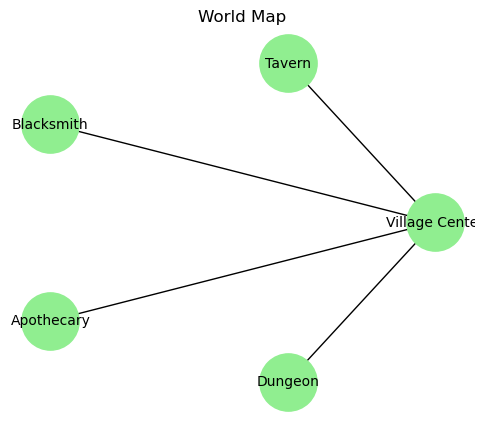

What room am I in  


You are currently in Room R2 of the dungeon. The room has dark stone walls covered in moss, and you can hear the faint sound of dripping water in the distance. There are pathways leading further into the dungeon.

Would you like to explore this room, investigate something specific, or choose another action? 

Please specify your next action. 

{'player': {'class_name': 'fighter', 'hp_full': 95, 'hp_curr': 95, 'atk_base': 15, 'atk_curr': 15, 'weapon': 'sword'}, 'player_weapon_maxed': False, 'player_weapon': None, 'group': None, 'inventory': [], 'available_locations': {'village_locations': {'Village Center': {'description': None, 'available_interactables': None}, 'Tavern': {'description': None, 'available_interactables': None, 'available_quests': None}, 'Blacksmith': {'description': None, 'shop_items': None}, 'Apothecary': {'description': None, 'shop_items': None}, 'Dungeon': {'description': None}}, 'dungeon_rooms': {'R1': {'description': None, 'available_interactio

In [60]:
ai_chat()